# Experiment on finance data

Dataset used is the currency enchange with respect to USD dollars, from daily measurements from the last 2 years (2017-2018).

Currencies used: 
- Reference: USA
- Canadian dollar (CAD)
- Euro (EUR)
- Japanese yen (JPY)
- Great british pound (GBP)
- Swiss franc (CHF)
- Austrial dollar (AUD)
- Hong Kong dollar (HKD)
- New zealand dollar (NZD)
- South korean won (KRW)
- Mexican peso (MXN)


**Question** how to treat sampling values when input is not time

---

Inflation data 
https://data.oecd.org/price/inflation-cpi.htm


Priors for magnitude:

currency_prior = np.array([1, 1, 3.5, 1, 1, 1, 1, 1, 50., 1])

gonu_prior = np.array([1352., 84.   ,8038.,  128.])

In [1]:
import mogptk

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

In [2]:
# plot config
sns.set_context('paper', font_scale=1.4)
sns.set_style('ticks')
plt.rcParams['figure.figsize'] = (10, 5)

## Load dataset

In [3]:
df = pd.read_csv('data/currency_exchange/final_dataset.csv')
cols = list(df)[3:]
cols[0], cols[1] = cols[1], cols[0]
cols

['EUR/USD',
 'CAD/USD',
 'JPY/USD',
 'GBP/USD',
 'CHF/USD',
 'AUD/USD',
 'HKD/USD',
 'NZD/USD',
 'KRW/USD',
 'MXN/USD']

In [4]:
# cut to only 2017
idx = pd.to_datetime(df['Unnamed: 0']) < np.datetime64('2018-01-01')
df = df[idx]

In [5]:
data = []
for c in cols:
    data.append(mogptk.Data(X=df['Day'].values,
                            Y=df[c].values,
                            name=c))
for d in data:
    d.transform(mogptk.TransformDetrend)

## Create and fit model

Remove data to simulate sensor failure

In [6]:
# randomly sample from the data
for channel in data:
    channel.remove_randomly(pct=0.3)

# drop chunks to simulate sensor failure
last_day = df['Day'].iloc[-1]

data[0].remove_range(last_day, None)
data[1].remove_range(90, 120)
# data[2].remove_range(480, 520)
data[2].remove_range(last_day, None)
data[3].remove_range(200, 250)
data[4].remove_range(None, 30)
# data[5].remove_range(None, 30)
data[5].remove_range(last_day, None)
data[7].remove_range(None, 30)

cols2keep = [0, 2, 5]

for i in range(1, len(cols)):
    if i not in cols2keep:
         data[i].remove_range(last_day - 40, None)

# add pred values

# use data class
x_test = [channel.X[~channel.mask] for channel in data]
y_test = [df[cols[i]].values[~data[i].mask] for i in range(len(cols))]

In [7]:
cols = [c.split('/')[0] for c in cols]

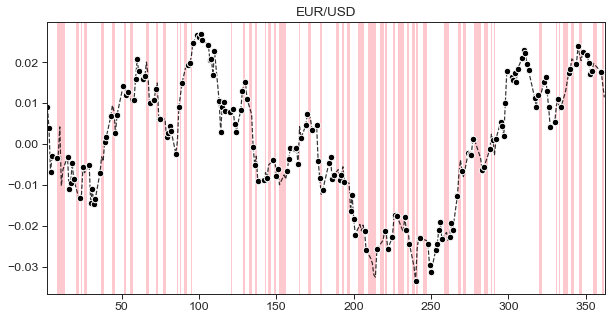

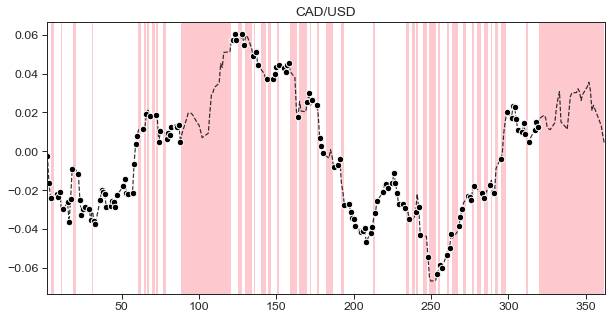

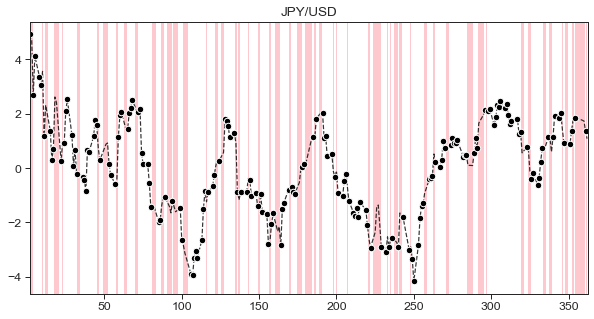

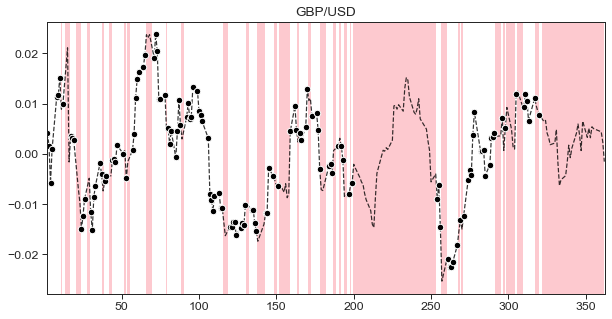

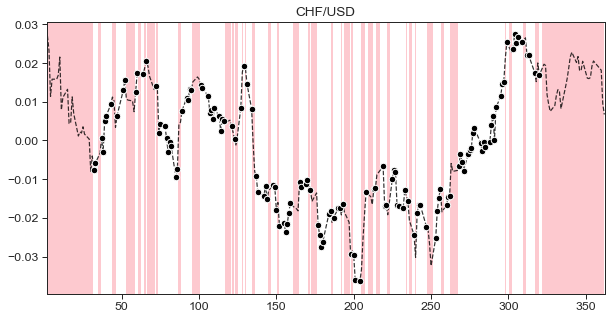

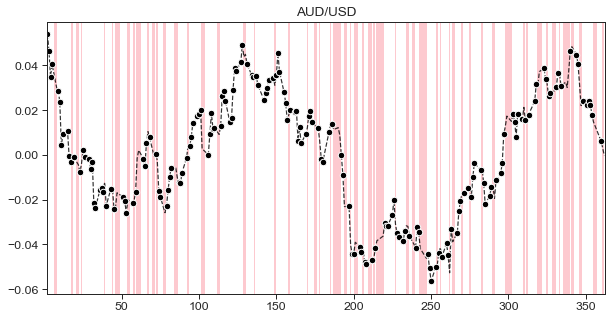

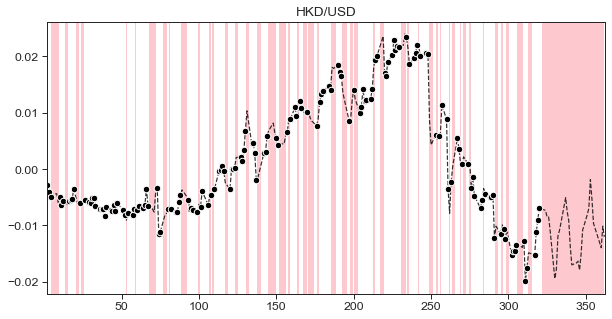

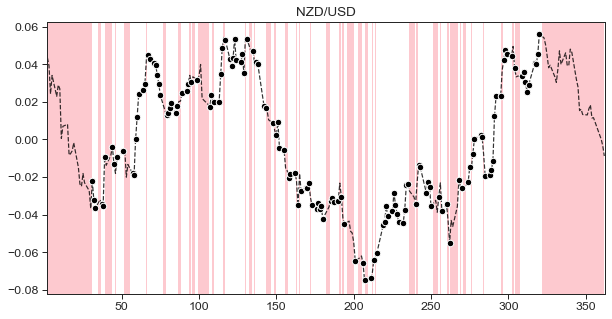

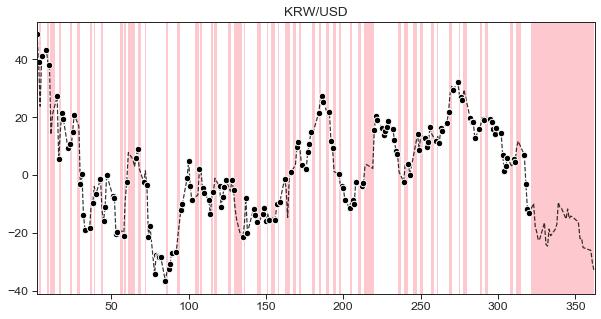

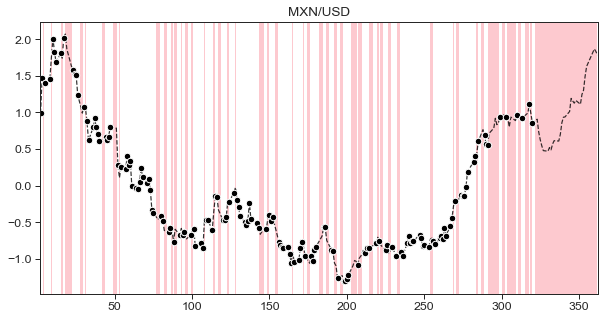

In [8]:
for i in range(10):
    data[i].plot()
    plt.show()

## MOSM

In [11]:
%%time
n_trials = 1

mosm_list = []
mosm_mae = np.zeros((n_trials, len(cols)))
mosm_nmae = np.zeros((n_trials, len(cols)))
mosm_rmse = np.zeros((n_trials, len(cols)))
mosm_nrmse = np.zeros((n_trials, len(cols)))

for n in range(n_trials):
    model_mosm = mogptk.MOSM(data, Q=5)
    model_mosm.init_parameters('BNSE')
    
    print('Starting trial', n)
    model_mosm.train(method='L-BFGS-B', maxiter=1000, tol=1e-10)
    print('Finished trial', n)
    print('='*50)        
    
    mosm_list.append(model_mosm)
    
    # errors per channel
    error = mogptk.test_errors(model_mosm, x_test=x_test, y_test=y_test)
    
    mosm_mae[n, :] = np.array(error[0])[:, 0]
    mosm_nmae[n, :] = np.array(error[0])[:, 1]
    mosm_rmse[n, :] = np.array(error[0])[:, 2]
    mosm_nrmse[n, :] = np.array(error[0])[:, 3]
    

Starting trial 0
Finished trial 0
CPU times: user 1h 15min 26s, sys: 1min 35s, total: 1h 17min 2s
Wall time: 1h 11min 31s


In [12]:
pd.DataFrame(np.c_[
    mosm_mae.mean(0), mosm_nmae.mean(0), mosm_rmse.mean(0),
    mosm_mae.std(0), mosm_nmae.std(0), mosm_rmse.std(0)],
    columns=['MAE', 'nmae', 'RMSE', 'MAE std', 'nmae% std', 'RMSE std'])

,MAE,nmae,RMSE,MAE std,nmae% std,RMSE std
0,0.002942,0.024731,0.003636,0.0,0.0,0.0
1,0.006236,0.039316,0.008056,0.0,0.0,0.0
2,0.420196,0.049905,0.580791,0.0,0.0,0.0
3,0.005254,0.055953,0.006871,0.0,0.0,0.0
4,0.005483,0.068250,0.007459,0.0,0.0,0.0
5,0.004605,0.039362,0.005742,0.0,0.0,0.0
6,0.002637,0.036682,0.003734,0.0,0.0,0.0
7,0.010198,0.075931,0.014399,0.0,0.0,0.0
8,5.563487,0.042862,7.772219,0.0,0.0,0.0
9,0.207418,0.048103,0.382094,0.0,0.0,0.0


In [13]:
mosm_mae = np.zeros((n_trials, len(cols)))
mosm_nmae = np.zeros((n_trials, len(cols)))
mosm_rmse = np.zeros((n_trials, len(cols)))
mosm_nrmse = np.zeros((n_trials, len(cols)))

for model in mosm_list:
    error = mogptk.test_errors(model, x_test=x_test, y_test=y_test)
    
    mosm_mae[n, :] = np.array(error[0])[:, 0]
    mosm_nmae[n, :] = np.array(error[0])[:, 1]
    mosm_rmse[n, :] = np.array(error[0])[:, 2]
    mosm_nrmse[n, :] = np.array(error[0])[:, 3]

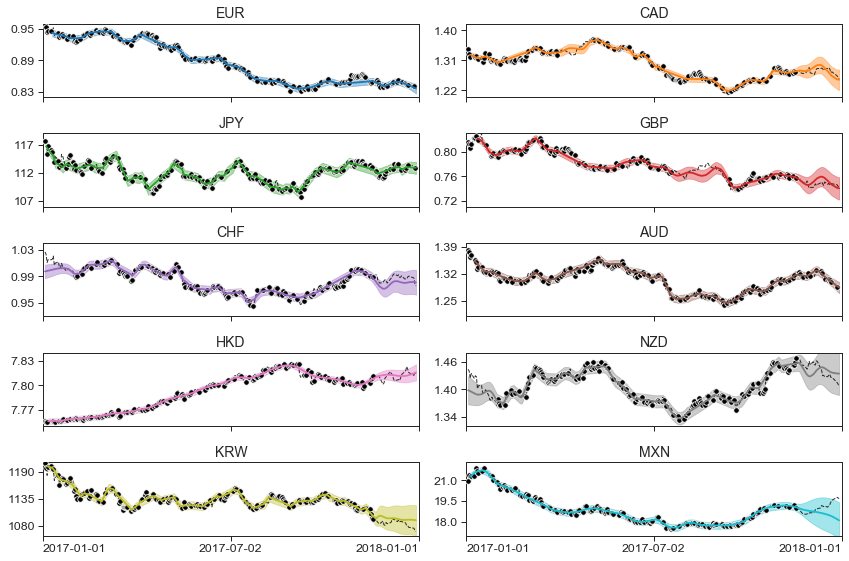

In [18]:
best_model = mosm_list[np.argmin(mosm_nmae.mean(1))]

ylims = [(0.82, .96), (1.20, 1.42),
         (106, 119), (0.71, 0.83),
         (0.93, 1.04), (1.21, 1.4),
         (7.75, 7.84), (1.32, 1.48),
         (1060, 1210), (17, 22.3)]

yticks = [(0.83, .95), (1.22, 1.4),
          (107, 117), (0.72, 0.8),
          (0.95, 1.03), (1.25, 1.39),
          (7.77, 7.83), (1.34, 1.46),
          (1080, 1190), (18, 21)]


ylims2 = [(0.82, .89), (1.20, 1.32),
         (106, 116), (0.72, 0.79),
         (0.93, 1.01), (1.21, 1.35),
         (7.795, 7.835), (1.32, 1.49),
         (1060, 1170), (17, 20)]

yticks2 = [(0.83, .87), (1.21, 1.31),
           (107, 115), (0.73, 0.78),
           (0.95, 0.99), (1.23, 1.33),
           (7.80, 7.83), (1.35, 1.45),
           (1080, 1150), (17.5, 19.5)]


f, axarr = best_model.plot_prediction(
                       grid=(5, 2),
                       names=cols,
                       title='',
                       ylims=ylims,
                       figsize=(12, 8));

for i in range(len(cols)):
    axarr[i].set_title(cols[i], fontsize=14)
    axarr[i].set_yticks(np.linspace(yticks[i][0], yticks[i][1], 3))

    channel = best_model.dataset[i]

    # xlabels = pd.date_range(df['Unnamed: 0'].iloc[0], df['Unnamed: 0'].iloc[-1], periods=9).date
    # xticks = [formatter._parse(str(label)) for label in xlabels]
    
    xlabels = pd.date_range('2017-01-01', '2018-01-01', periods=3)
    xticks = (xlabels - np.datetime64('2017-01-01')).days.values
    
    new_xlabels = xlabels.date
    # new_xlabels[1::2] = ['']
    # xlabels[::2][2:] += datetime.timedelta(days=1)
    # new_xlabels[::2] = xlabels[::2]
    
    axarr[i].set_xticks(xticks)
    if i>= 8:
         axarr[i].set_xticklabels(new_xlabels)
    else:
         axarr[i].set_xticklabels([])

    axarr[i].set_xlim(xticks[0], xticks[-1])
    
    xlabel_list = [item for item in axarr[i].get_xticklabels()]
    if i>=8:
        xlabel_list[0].set_ha('left')
        xlabel_list[-1].set_ha('right')
plt.tight_layout()

# plt.savefig('output/mosm_exchange_rate_zoomed.pdf', bbox_inches='tight')
# plt.savefig('output/mosm_exchange_rate.pdf', bbox_inches='tight')

In [20]:
model_mosm._get_cross_parameters()['delay'][:, :, 0, :].max()

0.743997922834446

## CSM

In [27]:
%%time
n_trials = 1

csm_mae = np.zeros((n_trials, len(cols)))
csm_nmae = np.zeros((n_trials, len(cols)))
csm_rmse = np.zeros((n_trials, len(cols)))
csm_nrmse = np.zeros((n_trials, len(cols)))

csm_list = []

for n in range(n_trials):
    model_csm = mogptk.CSM(data, Q=5)
    model_csm.init_parameters('BNSE')
    
    print('Starting trial', n)
    model_csm.train(method='L-BFGS-B', maxiter=1000, tol=1e-10)
    print('Finished trial', n)
    print('='*50)
    csm_list.append(model_csm)
    
    # errors per channel
    error = mogptk.test_errors(model_csm, x_test=x_test, y_test=y_test)
    
    csm_mae[n, :] = np.array(error[0])[:, 0]
    csm_nmae[n, :] = np.array(error[0])[:, 1]
    csm_rmse[n, :] = np.array(error[0])[:, 2]
    csm_nrmse[n, :] = np.array(error[0])[:, 3]

Starting trial 0
Finished trial 0
CPU times: user 23min 53s, sys: 1min 13s, total: 25min 7s
Wall time: 21min 26s


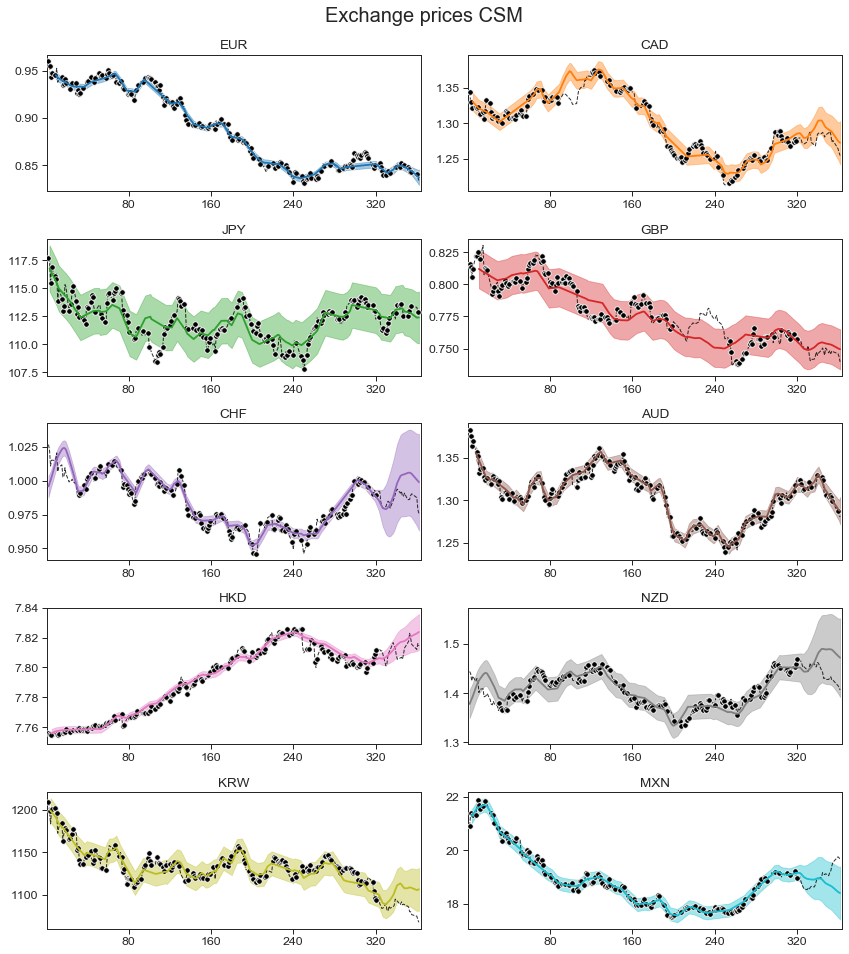

In [28]:
best_csm = csm_list[np.argmin(csm_nmae.mean(1))]

model_csm.plot_prediction(grid=(5, 2), names=cols, title='Exchange prices CSM');

In [29]:
csm_errors = []
for model in csm_list:
    csm_errors.append(mogptk.test_errors(model, x_test=x_test, y_test=y_test, raw_errors=True))

## SM-LMC

In [30]:
%%time
n_trials = 1

smlmc_mae = np.zeros((n_trials, len(cols)))
smlmc_nmae = np.zeros((n_trials, len(cols)))
smlmc_rmse = np.zeros((n_trials, len(cols)))
smlmc_nrmse = np.zeros((n_trials, len(cols)))

smlmc_list = []

for n in range(n_trials):
    print('Trial ', n)
    model_smlmc = mogptk.SM_LMC(data, Q=5)
    model_smlmc.init_parameters('BNSE')
    
    model_smlmc.train(method='L-BFGS-B', maxiter=1000, tol=1e-10)
    
    smlmc_list.append(model_smlmc)
    
    error = mogptk.test_errors(model_smlmc, x_test=x_test, y_test=y_test)
    
    smlmc_mae[n, :] = np.array(error[0])[:, 0]
    smlmc_nmae[n, :] = np.array(error[0])[:, 1]
    smlmc_rmse[n, :] = np.array(error[0])[:, 2]
    smlmc_nrmse[n, :] = np.array(error[0])[:, 3]

Trial  0
CPU times: user 16min 25s, sys: 1min 4s, total: 17min 29s
Wall time: 14min 44s


In [31]:
pd.DataFrame(np.c_[
    smlmc_mae.mean(0), smlmc_nmae.mean(0), smlmc_rmse.mean(0),
    smlmc_mae.std(0), smlmc_nmae.std(0), smlmc_rmse.std(0)],
    columns=['MAE', 'nmae%', 'RMSE', 'MAE std', 'nmae% std', 'RMSE std'])

,MAE,nmae%,RMSE,MAE std,nmae% std,RMSE std
0,0.003362,0.028261,0.004157,0.0,0.0,0.0
1,0.010875,0.068571,0.014641,0.0,0.0,0.0
2,0.871889,0.103550,1.051607,0.0,0.0,0.0
3,0.014908,0.158769,0.025114,0.0,0.0,0.0
4,0.004096,0.050992,0.005337,0.0,0.0,0.0
5,0.005287,0.045186,0.006221,0.0,0.0,0.0
6,0.005250,0.073017,0.007450,0.0,0.0,0.0
7,0.011797,0.087841,0.014485,0.0,0.0,0.0
8,21.690071,0.167104,39.162870,0.0,0.0,0.0
9,0.319694,0.074141,0.614656,0.0,0.0,0.0


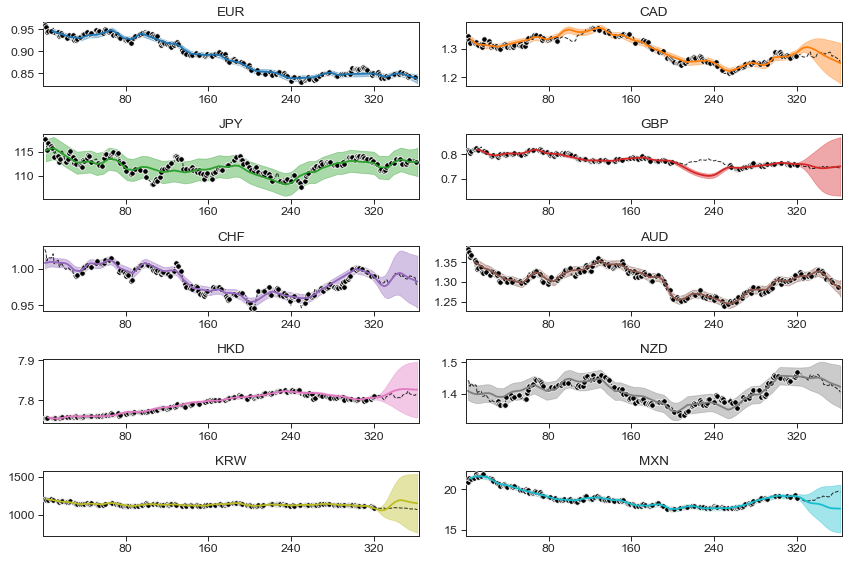

In [32]:
best_smlmc = smlmc_list[np.argmin(smlmc_nmae.mean(1))]
best_smlmc.plot_prediction(
                       grid=(5, 2),
                       names=cols,
                       title='',
                       figsize=(12, 8));

In [33]:
smlmc_errors = []
for model in smlmc_list:
    smlmc_errors.append(mogptk.test_errors(model, x_test=x_test, y_test=y_test, raw_errors=True))

## IGP
Independant gaussian process with spectral mixture kernel

In [34]:
%%time
n_trials = 1

igp_mae = np.zeros((n_trials, len(cols)))
igp_nmae = np.zeros((n_trials, len(cols)))
igp_rmse = np.zeros((n_trials, len(cols)))
igp_nrmse = np.zeros((n_trials, len(cols)))

for n in range(n_trials):
    print('Trial ', n)
    
    igp_list = []
    
    for i in range(len(cols)):
        
        data[i].X = data[i].X.astype(float)
        
        model_sm = mogptk.SM(data[i], Q=3)
        model_sm.init_parameters('BNSE')
        model_sm.train(method='L-BFGS-B', maxiter=1000, tol=1e-10)
        
        igp_list.append(model_sm)
        
        error = mogptk.test_errors(model_sm, x_test=[x_test[i]], y_test=[y_test[i]])
    
        igp_mae[n, i] = np.array(error[0])[:, 0]
        igp_nmae[n, i] = np.array(error[0])[:, 1]
        igp_rmse[n, i] = np.array(error[0])[:, 2]
        igp_nrmse[n, i] = np.array(error[0])[:, 3]
    print('='*50)

Trial  0
CPU times: user 1min 19s, sys: 4.61 s, total: 1min 23s
Wall time: 50.7 s


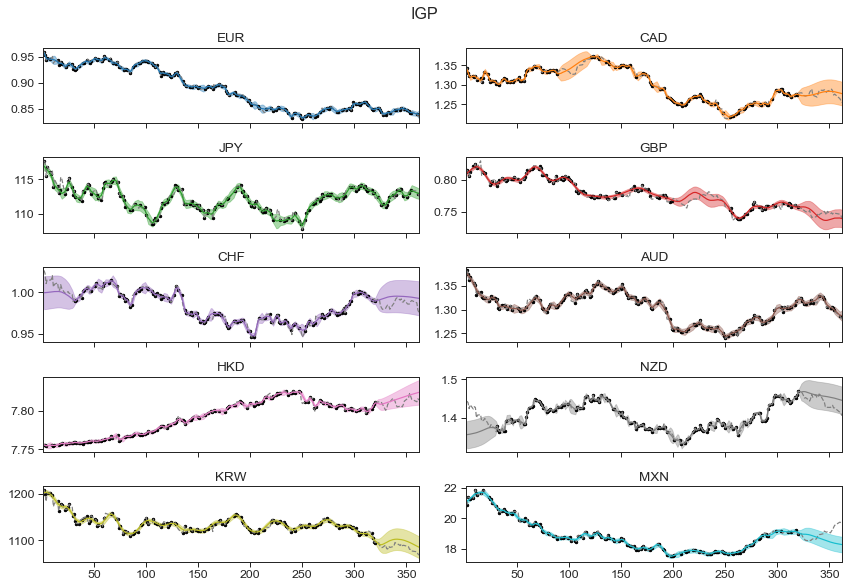

In [42]:
f, axarr = plt.subplots(5, 2, sharex=True, figsize=(12, 8))
axarr = axarr.reshape(-1)

for i in range(len(cols)):
    c = igp_list[i].dataset[0]
    x_train = c.X[c.mask,:]
    y_train = c._detransform(c.Y[c.mask], c.X[c.mask,:])
    
    x_all = c.X
    y_all = c._detransform(c.Y, c.X)
    
    x_pred = c.X
    mean_pred, lower_ci, upper_ci = igp_list[i].predict([x_pred])
    
    axarr[i].plot(x_train[:, 0], y_train, '.k', label='Train', )
    axarr[i].plot(x_all[:, 0], y_all, '--', label='Test', c='gray')

    axarr[i].plot(x_pred[:, 0], mean_pred[0], label='Post.Mean', c=sns.color_palette()[i%10])
    axarr[i].fill_between(x_pred[:, 0].reshape(-1),
                          lower_ci[0],
                          upper_ci[0],
                          label='95% c.i',
                          color=sns.color_palette()[i%10],
                          alpha=0.4)

    # axarr[i].legend(ncol=4, loc='upper center', fontsize=8)
    axarr[i].set_xlim(x_all[0]-1, x_all[-1])

    # set channels name
    
    axarr[i].set_title(cols[i])

plt.suptitle('IGP', y=1.02)
plt.tight_layout()

## Compare All

In [43]:
print('{:.3e}, {:.3e}'.format(mosm_nmae[:, :].mean(),
      csm_nmae[:, :].mean())
      #smlmc_nmae[:, :].mean(),
      #igp_nmae[:, :].mean()
     )

4.811e-02, 7.112e-02


In [44]:
print('nMAE: smlmc {:.3e} pm {:.3e} | igp {:.3e} pm {:.3e}'.format(
        smlmc_nmae[:, :].mean(),
        smlmc_nmae[:, :].std(),
        igp_nmae[:, :].mean(),
        igp_nmae[:, :].std(),
    )
     )

nMAE: smlmc 8.574e-02 pm 4.361e-02 | igp 4.978e-02 pm 2.109e-02


In [45]:
print('nRMSE: smlmc {:.3e} pm {:.3e} | igp {:.3e} pm {:.3e}'.format(
        smlmc_nrmse[:, :].mean(),
        smlmc_nrmse[:, :].std(),
        igp_nrmse[:, :].mean(),
        igp_nrmse[:, :].std(),
    )
     )

nRMSE: smlmc 1.295e-01 pm 8.375e-02 | igp 7.307e-02 pm 3.815e-02


In [46]:
print('{:.3e}, {:.3e}'.format(mosm_nmae[:, :].std(),
      csm_nmae[:, :].std())
      #smlmc_nmae[:, :].std(),
      #igp_nmae[:, :].std()
     )

1.450e-02, 3.668e-02


In [47]:
print('{:.3e}, {:.3e}'.format(mosm_nrmse[:, :].mean(),
      csm_nrmse[:, :].mean())
      #smlmc_nrmse[:, :].mean(),
      #igp_nrmse[:, :].mean()
     )

6.731e-02, 9.520e-02


In [48]:
print('{:.3e}, {:.3e}'.format(mosm_nrmse[:, :].std(),
      csm_nrmse[:, :].std())
      #smlmc_nrmse[:, :].std(),
      #igp_nrmse[:, :].std()
     )

2.232e-02, 4.789e-02


# Load errors

In [49]:
mosm_nmae.mean()

0.04810946667481792

In [54]:
print('mosm nMAE {:.3e} pm {:.3e} | mosm nRMSE {:.3e} pm {:.3e}'.format(
        mosm_nmae.mean(1).mean(),
        mosm_nmae.mean(1).std(),
        mosm_nrmse.mean(1).mean(),
        mosm_nrmse.mean(1).std()))

mosm nMAE 0.000e+00 pm 0.000e+00 | mosm nRMSE 0.000e+00 pm 0.000e+00


In [53]:
print('csm nMAE {:.3e} pm {:.3e} | csm nRMSE {:.3e} pm {:.3e}'.format(
        csm_nmae.mean(1).mean(),
        csm_nmae.mean(1).std(),
        csm_nrmse.mean(1).mean(),
        csm_nrmse.mean(1).std()))

csm nMAE 7.112e-02 pm 0.000e+00 | csm nRMSE 9.520e-02 pm 0.000e+00


In [52]:
print('smlmc nMAE {:.3e} pm {:.3e} | smlmc nRMSE {:.3e} pm {:.3e}'.format(
        smlmc_nmae.mean(1).mean(),
        smlmc_nmae.mean(1).std(),
        smlmc_nrmse.mean(1).mean(),
        smlmc_nrmse.mean(1).std()))

smlmc nMAE 8.574e-02 pm 0.000e+00 | smlmc nRMSE 1.295e-01 pm 0.000e+00


In [51]:

print('igp nMAE {:.3e} pm {:.3e} | igp nRMSE {:.3e} pm {:.3e}'.format(
        igp_nmae.mean(1).mean(),
        igp_nmae.mean(1).std(),
        igp_nrmse.mean(1).mean(),
        igp_nrmse.mean(1).std()))

igp nMAE 4.978e-02 pm 0.000e+00 | igp nRMSE 7.307e-02 pm 0.000e+00
